# Active Subspace Analysis on Runoff With Variable Permeability Fields

##### James Gilbert, Colorado School of Mines, <jagilber@mines.edu>
##### Jennifer Jefferson, Colorado School of Mines, <jejeffer@mines.edu>
##### Paul Constantine, Colorado School of Mines, <pconstan@mines.edu>
##### Reed Maxwell, Colorado School of Mines, <rmaxwell@mines.edu>
##### Ryan Howard, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces methodology and results on runoff from an integrated hydrologic model with varying permeability fields, presented in [[1]][R1].

### Introduction

Overland water flow (runoff) is an important hydrologic phenomenon that drives associated processes such as erosion and contaminant transport. There are two primary mechanisms generating runoff: Dunnian, in which the soil is saturated and adding additional water must force existing water out of the soil, and Hortonian, in which the rate of precipitation exceeds the rate at which the soil can absorb water. In both cases, downslope effects of upslope runoff depend on the characteristics of the intervening land and may be sensitive to heterogeneity in such properties. Here, we'll study the relationship between accumulated runoff volume and changes in spatially varying permeability fields using the active subspaces methodology and the integrated hydrologic model ParFlow.

### Active Subspaces

_Active Subspaces_ is a method of dimension reduction that identifies important directions in the input space, along which perturbations in inputs change the output more than in the orthogonal directions. We consider the model's the output, $f$ (total runoff volume in our case), as a function of the normalized input parameters, $\mathbf x$ (parameters characterizing the subsurface permeability in our case): $f = f(\mathbf x)$. The active subspaces methodology is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T \rho(\mathbf x)\ d\mathbf x = \mathbf W \Lambda\mathbf W^T,
$$

where $\rho$ is a probability density on $\mathbf x$ and $\mathbf W \Lambda\mathbf W^T$ is the eigendecomposition of $\mathbf C$ (the diagonal of $\Lambda$ contains the eigenvalues of $\mathbf C$ in descending order, and $\mathbf W$'s columns contain the corresponding eigenvectors). These satisfy the relationship: $\int\left(\nabla f^T\mathbf w_i\right)^2\rho\ d\mathbf x = \lambda_i$. This means the $i^{th}$ eigenvalue quantifies how much $f$ changes, on average, in the direction defined by $\mathbf w_i$. If the first few eigenvalues are large compared to the rest, the corresponding eigenvectors define an 'important' subspace along which perturbations in $\mathbf x$ tend to change $f$ more than in the orthogonal directions.

One way to estimate the matrix $\mathbf C$ is with simple Monte Carlo: sample many $\mathbf x$'s according to $\rho$, compute gradients at each of these points, and use these to approximate $\mathbf C$. However, in may applications (including ours), we do not have direct access to these gradients. Furthermore, approximating the gradients using finite differences can be prohibitively expensive (requiring $m+1$ model evaluations per gradient sample with $m$ parameters). We therefore use the following method to approximate the _single_ most important direction in the parameter space:

1. Draw $\{\mathbf x_i\}_{i=1}^N$ from $\rho$, where $N = O(m)$.
2. Compute $f_i = f(\mathbf x_i)$ for each $i$.
3. Use least-squares to approximate the coefficients, $a_0$ and $\mathbf a$, of the linear model: $f_i = a_0 + \mathbf a^T\mathbf x_i$.
4. $\hat{\mathbf w} = \mathbf a/||\mathbf a||$ is the vector identifying the most important direction in the input space.

This heuristic tends to work well if $f$ is monotonic in each component of $\mathbf x$, but it can only identify a 1-dimensional active subspace; if a higher-dimensional space is required, this method will fail. $\hat{\mathbf w}$'s components can be used as a measure of sensitivity to the corresponding parameter: larger-magnitude components identify relative sensitivity.

### The Integrated Hydrologic Model

We use the integrated hydrologic code ParFlow to simulate surface and subsurface flows in an idealized tilted-v domain. The code requires as inputs various properties of the surface and subsurface. All properties are spatially uniform except subsurface permeability, which we allow to vary (see Table 1 of [[1]][R1] for more on the other inputs). To model the permeability, we assume the log permeability field is a Gaussian random field, completely characterized by its mean function, $\mu(\mathbf s)$ and its two-point correlation function, $C(\mathbf s, \mathbf t)$, where $\mathbf s$ and $\mathbf t$ are points in the domain. We assume the correlation function has eigenfunction/eigenvalue pairs:

$$
\int C(\mathbf s, \mathbf t)\phi_i(\mathbf s)d\mathbf s = \sigma_i^2\phi_i(\mathbf t),\ i=1,\dots.
$$

We can approximate the Gaussian field with a truncated Karhunen-Loéve (KL) series:

$$
\log(\kappa(\mathbf s))\approx \mu(\mathbf s) + \sum_{i=1}^m\sigma_i\phi_i(\mathbf s)X_i,
$$

where the $X_i$ are independent standard Gaussian random variables. We treat $\{X_i\}_{i=1}^m$ as our input parameters; a realization of $\{X_i\}$ will produce a realization of the log-permeability which can be used in the ParFlow simulation. We choose $m$ to be 100 since we find this value to result in sufficiently accurate KL representations.

We study two runoff cases: a Hortonian (initially unsaturated) case where we indtroduce precipitation on an initially deep water table, and a Dunnian (initially saturated) case where we initialize a near-surface water table and do not have precipitation. Each case is run 10000 times with inputs ($\{X_i\}_{i=1}^{100}$) selected from $\rho$ (a standard Gaussian distribution).

### References:

[[1]][R1] Global spatial sensitivity of runoff to subsurface permeability using the active subspace method, _Advances in Water Resources_

[[2]][R2] Active Subspace Methods in Theory and Practice: Applications to Kriging Surfaces, _SIAM Journal of Scientific Computing_

[R1]: http://dx.doi.org/10.1016/j.advwatres.2016.03.020
[R2]: http://dx.doi.org/10.1137/130916138

<br>

We'll now code up the analysis using the [Python Active-subspaces Utility Library](https://github.com/paulcon/active_subspaces).

In [1]:
import numpy as np
import pandas as pn
import active_subspaces as ac
import matplotlib.pyplot as plt
%matplotlib inline

Import the data set, which contains 10,000 sets of input parameters and corresponding runoff values.

In [2]:
#Input values
XX = pn.DataFrame.from_csv('inputs-ShortCorr.GW02.txt', None, ' ', None).as_matrix()[:,:]
#Output values for the initially saturated (f_sat) and unsaturated (f_unsat) cases
f_sat = pn.DataFrame.from_csv('RunOff02_Saturated_10k.txt', header=None, index_col=None)\
    .as_matrix()[:,:]
f_unsat = pn.DataFrame.from_csv('RunOff02_Unsaturated_10k.txt', header=None, index_col=None)\
    .as_matrix()[:,:]

out_labels = ['Dunnian (Saturated) Case', 'Hortonian (Unsaturated) Case']

Compute the active subspace.

In [3]:
#subspaces for the saturated and unsaturated cases
ss_sat = ac.subspaces.Subspaces()
ss_unsat = ac.subspaces.Subspaces()

#Compute the active subspace
ss_sat.compute(X=XX, f=f_sat, sstype=5, nboot=500)
ss_unsat.compute(X=XX, f=f_unsat, sstype=5, nboot=500)

Plot components of $\hat{\mathbf w}$ and summary plots (plots of the output vs the active variable, $\hat{\mathbf w}^T\mathbf x$) (see also Figure7 of [[1]][R1]).

[R1]: http://dx.doi.org/10.1016/j.advwatres.2016.03.020

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


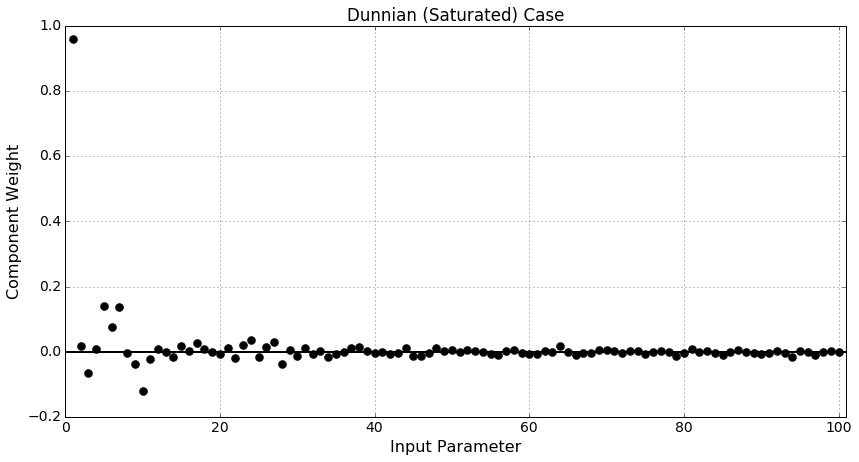

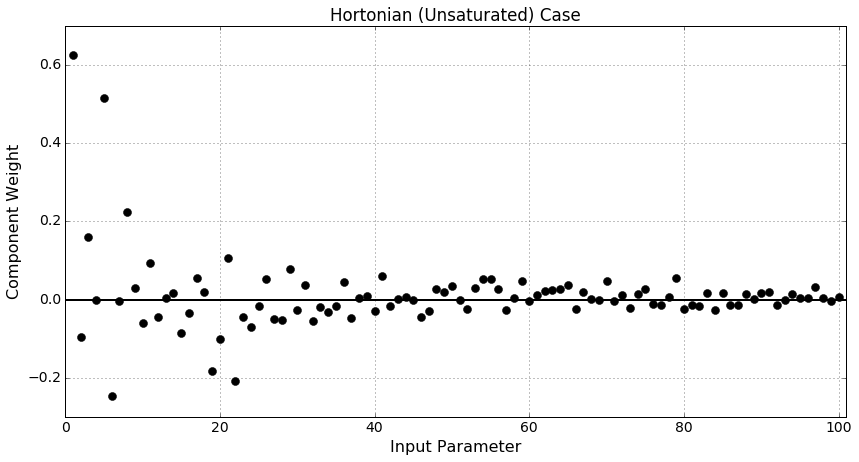

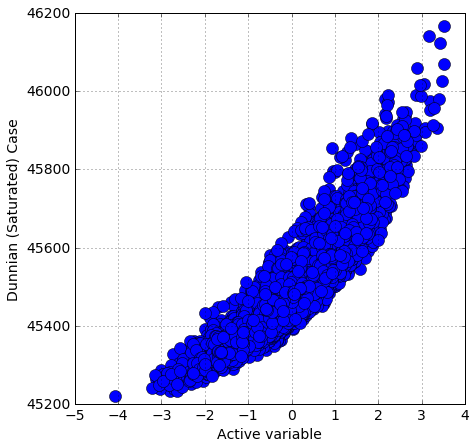

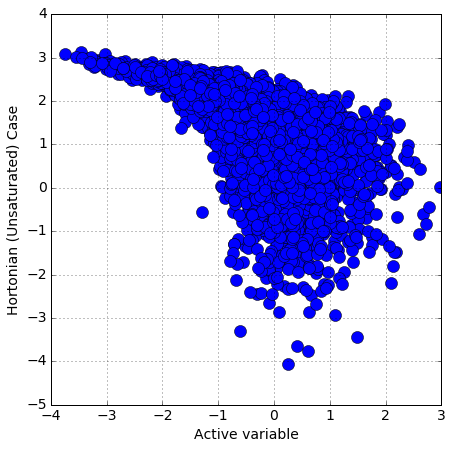

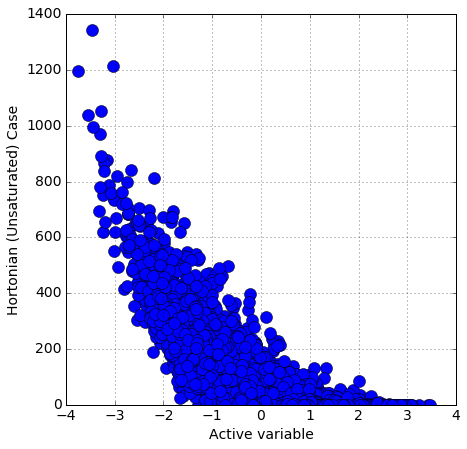

In [4]:
#saturated case
plt.figure(figsize=(14, 7))
plt.xlim((0, 101))
plt.plot(np.arange(1, 101), ss_sat.W1, 'ko', markersize=8)
plt.hlines(0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linewidth=2)
plt.grid(True)
plt.xlabel('Input Parameter', fontsize=16)
plt.ylabel('Component Weight', fontsize=16)
plt.title(out_labels[0])

#unsaturated case
plt.figure(figsize=(14, 7))
plt.xlim((0, 101))
plt.plot(np.arange(1, 101), ss_unsat.W1, 'ko', markersize=8)
plt.hlines(0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], linewidth=2)
plt.grid(True)
plt.xlabel('Input Parameter', fontsize=16)
plt.ylabel('Component Weight', fontsize=16)
plt.title(out_labels[1])

#summary plots as presented in the paper, note the log scale used in the unsaturated case
ac.utils.plotters.sufficient_summary(XX.dot(ss_sat.W1), f_sat, out_labels[0])
ac.utils.plotters.sufficient_summary(XX.dot(ss_unsat.W1), np.log10(f_unsat), out_labels[1])

#Summary plot for the unsaturated case using linear scaling (not presented in the paper)
ac.utils.plotters.sufficient_summary(XX.dot(ss_unsat.W1), f_unsat, out_labels[1])

There are some interesting differences between these two cases. The majority of weight in the Dunnian case is placed on the first component and the last 70 or so components are extremely close to 0. In the Hortonian case, much less weight is placed on the first component, and later components, while weighted low compared to the first few, are much further from 0 than the Dunnian case. Lower-indexed parameters correspond to large-scale heterogeneity while high-indexed parameters are associated with small-scale changes. The low weight on high-indexed parameters in the Dunnian case indicates it is only sensitive to large-scale heterogeneity while the comparatively high weight for the Hortonian case says it is sensitive to small-scale changes as well. 

The trend in the summary plots is also less tight in the Hortonian case; this could be due to a more complex relationship in the map from parameters to output in this case and might require a higher-dimensional subspace or a reparameterization to make the trend tighter.

Lastly, while the absolute ranges of the output are similar in both cases (the output values have a range of about 1000), the ranges relative to the respective averages are different: the Dunnian runoffs span about 45000 - 46000 while the Hortonian range is about 0 - 1000. This means that both cases share unit-for-unit sensitivity in terms of absolute marginal effects of marginal changes in the active variable but the Hortonian case is much more relatively sensitive in the sense that its changes in output are higher compared to its mean than in the Dunnian case.

### Conclusions

Overall, active subspaces have helped us in characterizing runoff sensitivity to heterogeneity in subsurface permeability for much less cost than would be necessary for a parameter study on the full input space. This methodology could be used in such applications as optimization and constraining an inverse problem. However, this investigation should be considered a proof-of-concept since we only varied permeability (without letting any other model inputs change), only searched for a 1-dimensional subspace with a heuristic method that might lead to sub-optimal results, and examined Dunnian and Hortonian runoff separately. Further research could vary many other model parameters, approximate gradients with finite differences or other methods to discover higher-dimensional subspaces, and examine the effects of Dunnian and Hortonian runoff simultaneously.